<a href="https://colab.research.google.com/github/AjayKuchhadiya/Speech-Human-Emotion-Detection-/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition using CNN with RAVDESS dataset


In [1]:
data_directory = "datasets/ravdess"

## 1. Download the dataset
<b>in Google Collab through drive

In [2]:
root_path = '/'

In [3]:
import os
os.chdir(root_path)

In [4]:
# !pip install PyDrive

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [6]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
if not os.path.exists('data'):
    os.makedirs('data')

downloaded = drive.CreateFile({'id':"1cuWdy5WSQ0wLbXKiNHsOsx0WEeoBkBxY"})   # replace the id with id of file you want to access
downloaded.GetContentFile('speech-emotion-recognition-ravdess-data.zip')

!mv speech-emotion-recognition-ravdess-data.zip data

if not os.path.exists(data_directory):
    os.makedirs(data_directory)

!unzip data/speech-emotion-recognition-ravdess-data.zip -d datasets/ravdess

Archive:  data/speech-emotion-recognition-ravdess-data.zip
replace datasets/ravdess/Actor_01/03-01-01-01-01-01-01.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## 2. Install and import libraries

In [9]:
# !pip install keras-utils
# !pip install keras-preprocessing

In [10]:

import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix, f1_score
import pickle
import keras
from keras import layers, Sequential
from keras.layers import Conv1D, Activation, Dropout, Dense, Flatten, MaxPooling1D
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# from keras.utils import np_utils
from tensorflow.keras import regularizers
from matplotlib import pyplot as plt
import seaborn as sn
import pandas as pd
import sklearn.metrics as metrics

## 3. Functions

In [11]:
# Emotions in the RAVDESS dataset, different numbers represent different emotion
emotions = {
    '01':'neutral',
    '02':'calm',
    '03':'happy',
    '04':'sad',
    '05':'angry',
    '06':'fearful',
    '07':'disgust',
    '08':'surprised'
}

**Extract features from audio files into numpy array**

In [12]:
def extract_feature(data, sr, mfcc, chroma, mel):

    """
    extract features from audio files into numpy array

    Parameters
    ----------
    data : np.ndarray, audio time series
    sr : number > 0, sampling rate
    mfcc : boolean, Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound
    chroma : boolean, pertains to the 12 different pitch classes
    mel : boolean, Mel Spectrogram Frequency

    """

    if chroma:
        stft = np.abs(librosa.stft(data))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(data, sr=sr, n_fft=2048).T,axis=0)
        result = np.hstack((result, mel))

    return result

#### Data Augmentation Techniques
There are two types of data augmentation for audio that we will be using

- Noise addition - add random white noises to the audio
- Shifting - shift the spectogram in a direction

**Add white noise to the audio dataset**

In [13]:
def noise(data, noise_factor):

    """
    add random white noises to the audio

    Parameters
    ----------
    data : np.ndarray, audio time series
    noise_factor : float, the measure of noise to be added

    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise

    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

**Shift the spectogram in a direction**

In [14]:
def shift(data, sampling_rate, shift_max, shift_direction):

    """
    shift the spectogram in a direction

    Parameters
    ----------
    data : np.ndarray, audio time series
    sampling_rate : number > 0, sampling rate
    shift_max : float, maximum shift rate
    shift_direction : string, right/both

    """
    shift = np.random.randint(sampling_rate * shift_max)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0

    return augmented_data

**Loading dataset**


In [15]:
def load_data(save=False):

    """
    loading dataset

    Parameters
    ----------
    save : boolean, save the data to disk as .npy

    """
    x, y = [], []
    for file in glob.glob(data_directory + "/Actor_*/*.wav"):
        # load an audio file as a floating point time series.
        data, sr = librosa.load(file)

        # extract features from audio files into numpy array
        feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
        x.append(feature)

        file_name = os.path.basename(file)

        # get emotion label from the file name
        emotion = emotions[file_name.split("-")[2]]
        y.append(emotion)

        # add noise to the data
        n_data = noise(data, 0.001)
        n_feature = extract_feature(n_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(n_feature)
        y.append(emotion)

        # shift the data
        s_data = shift(data,sr,0.25,'right')
        s_feature = extract_feature(s_data, sr, mfcc=True, chroma=True, mel=True)
        x.append(s_feature)
        y.append(emotion)

    if save==True:
        np.save('X', np.array(x))
        np.save('y', y)

    return np.array(x), y

## 3. Data processing

**Read in, extract features, and label data**

In [16]:
# !pip install librosa==0.8.0

In [17]:
X, y = load_data(save=True)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=9)

**Encode the data labels**

In [18]:
labelencoder = LabelEncoder()
labelencoder.fit(y_train)
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

{'angry': 0, 'calm': 1, 'disgust': 2, 'fearful': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprised': 7}


In [19]:
# Get the number of features extracted
print(f'Features extracted: {x_train.shape[1]}')

Features extracted: 180


## 4. Model training

**Define the model and optimizer**

In [25]:
model = Sequential()
model.add(Conv1D(256, 5,padding='same', input_shape=(180,1))) # 1st layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 2nd layer
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 3rd layer
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same', kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))) # 4th layer
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=8,
                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5)
                )
) # 7th layer
model.add(Activation('softmax'))

from tensorflow.keras.optimizers import schedules

lr_schedule = schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
opt = keras.optimizers.Adam(learning_rate = lr_schedule)

In [26]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

**Start training the model**

In [27]:
XProccessed = np.expand_dims(x_train, axis=2)
XTestProcessed = np.expand_dims(x_test, axis=2)
history = model.fit(XProccessed, y_train, epochs=100, validation_data=(XTestProcessed, y_test), batch_size=64)

Epoch 1/100
51/51 [==============================] - 22s 401ms/step - loss: 2.3631 - accuracy: 0.2123 - val_loss: 1.9573 - val_accuracy: 0.2935
Epoch 2/100
51/51 [==============================] - 24s 482ms/step - loss: 1.9257 - accuracy: 0.2991 - val_loss: 1.8860 - val_accuracy: 0.3500
Epoch 3/100
51/51 [==============================] - 20s 392ms/step - loss: 1.8021 - accuracy: 0.3691 - val_loss: 1.7201 - val_accuracy: 0.4009
Epoch 4/100
51/51 [==============================] - 22s 426ms/step - loss: 1.7568 - accuracy: 0.3809 - val_loss: 1.6873 - val_accuracy: 0.4139
Epoch 5/100
51/51 [==============================] - 19s 374ms/step - loss: 1.6621 - accuracy: 0.4247 - val_loss: 1.5770 - val_accuracy: 0.4593
Epoch 6/100
51/51 [==============================] - 20s 397ms/step - loss: 1.6013 - accuracy: 0.4500 - val_loss: 1.5375 - val_accuracy: 0.4815
Epoch 7/100
51/51 [==============================] - 19s 378ms/step - loss: 1.5084 - accuracy: 0.4867 - val_loss: 1.4599 - val_accuracy:

## 5. Model evaluation

- plot learning curve
- draw confusion matrix
- calculate F1 score

**Plot the learning curve of the model with its accuracy**

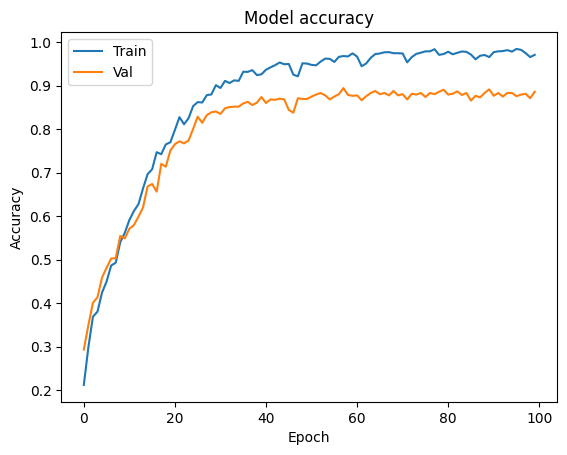

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

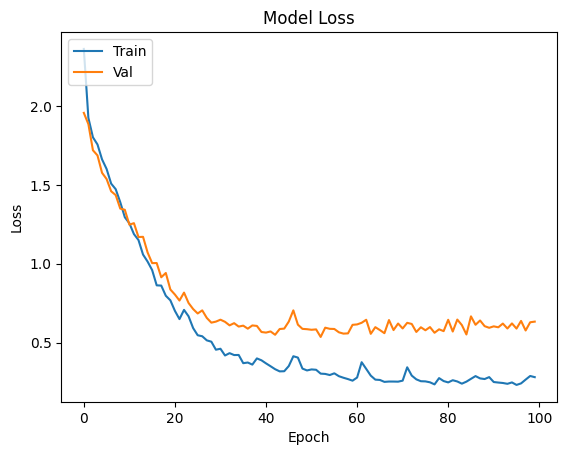

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

**Use the test data to do prediction**

In [30]:
y_pred = model.predict(XTestProcessed)

34/34 [==============================] - 2s 45ms/step


**Draw a confusion matrix**

<Axes: >

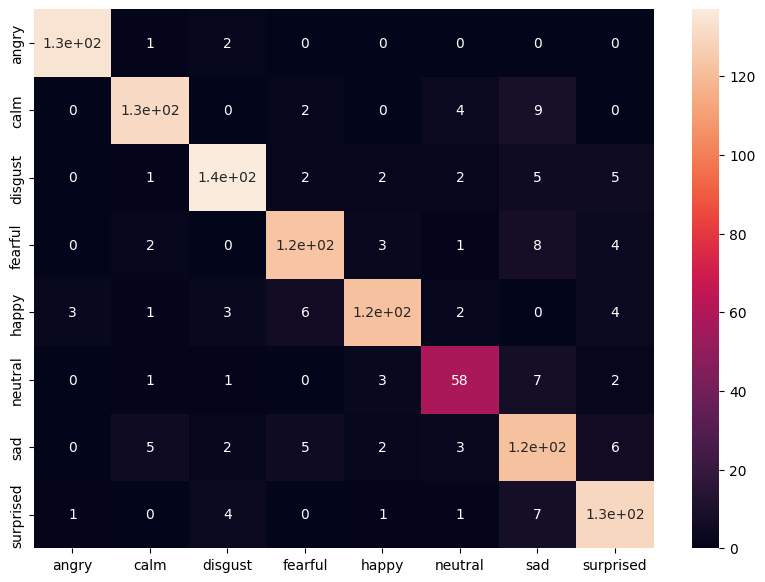

In [31]:
confusion_emotions = ['angry', 'calm', 'disgust', 'fearful','happy','neutral','sad','surprised']
cm=metrics.confusion_matrix(y_test,np.argmax(y_pred,axis=-1))
df_cm=pd.DataFrame(cm,index=[i for i in confusion_emotions],columns=[i for i in confusion_emotions])
plt.figure(figsize=(10,7))
sn.heatmap(df_cm,annot=True)

**Calculate the F1 score of the model**


In [32]:
f1_score(y_test,np.argmax(y_pred,axis=-1),average='weighted')

0.8866333772602778

**Model summary**

In [33]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 180, 256)          1536      
                                                                 
 activation_25 (Activation)  (None, 180, 256)          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 180, 128)          163968    
                                                                 
 activation_26 (Activation)  (None, 180, 128)          0         
                                                                 
 dropout_10 (Dropout)        (None, 180, 128)          0         
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 22, 128)           0         
 g1D)                                                            
                                                      

## 6. Save and load the trained model.

In [34]:
# Save the trained model to disk
if not os.path.exists('models'):
    os.makedirs('models')

model.save("models/cnn.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [35]:
# Load the model from disk
loaded_model = keras.models.load_model("models/cnn.h5")

## 7. Playground

In [36]:
# Load the data and extract features for each sound file
def load_single_data(file):
    x, y = [], []
    file_name = os.path.basename(file)
    emotion = emotions[file_name.split("-")[2]]
    data, sr = librosa.load(file)
    feature = extract_feature(data, sr, mfcc=True, chroma=True, mel=True)
    x.append(feature)
    y.append(emotion)
    return np.array(x), y

In [39]:
XX, yy = load_single_data("datasets/ravdess/Actor_01/03-01-05-02-02-02-01.wav")

In [40]:
yy

['angry']

In [43]:
# Predict for the test set
XXTemp=np.expand_dims(XX, axis=2)
XX, yy = load_single_data("data/ravdess/Actor_01/03-01-05-02-02-02-01.wav")
yy = model.predict(XXTemp)


1/1 [==============================] - 0s 37ms/step


In [44]:
list(y_pred)

[array([1.25782215e-11, 9.15358692e-11, 2.30015212e-06, 2.36122560e-05,
        1.70106352e-06, 3.77537113e-08, 9.99971449e-01, 8.93474294e-07],
       dtype=float32),
 array([2.5228819e-06, 5.2079722e-06, 6.1564560e-06, 4.4065160e-05,
        1.4696648e-02, 5.0088280e-04, 9.8464417e-01, 1.0020470e-04],
       dtype=float32),
 array([2.8086631e-06, 1.3901874e-08, 5.1959578e-06, 3.3393058e-01,
        6.6452914e-01, 2.9656159e-05, 2.0808244e-05, 1.4818700e-03],
       dtype=float32),
 array([7.5273547e-06, 4.4575961e-07, 3.2259573e-03, 6.7850620e-01,
        2.7716613e-01, 1.1122289e-05, 9.6766269e-03, 3.1405989e-02],
       dtype=float32),
 array([1.5905647e-12, 4.1166859e-06, 4.4806489e-12, 9.9999529e-01,
        2.1714202e-09, 1.9759534e-10, 4.8714918e-07, 6.9388083e-13],
       dtype=float32),
 array([1.4868073e-19, 2.7829454e-15, 2.5744211e-16, 9.9999994e-01,
        2.5374682e-09, 8.5129500e-18, 9.5704104e-12, 2.8091294e-12],
       dtype=float32),
 array([9.6872638e-16, 2.0105765